In [218]:
import sys
sys.path.insert(0, './python_lib')
import networkx as nx
import numpy as np
import graph_gen
import model
import imp
imp.reload(model)
import random
from collections import defaultdict
import torch
import math

In [219]:
%matplotlib inline

In [265]:
J_interaction

array([[0., 1., 0.],
       [1., 0., 1.],
       [0., 1., 0.]])

In [280]:
import imp
import bp_nn
imp.reload(bp_nn)
l = bp_nn.myLayer(1,1,N, torch.from_numpy(J_interaction).float(), True)

In [273]:
l.weight

Parameter containing:
tensor([[ 0.0000, -0.0737, -0.0000],
        [ 0.4035, -0.0000,  0.0460],
        [ 0.0000, -0.0217, -0.0000]], requires_grad=True)

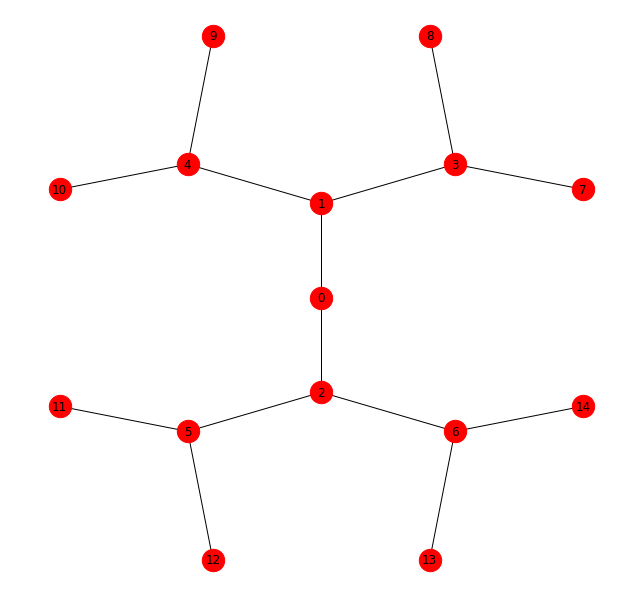

In [299]:
Degree = 3 # degree
Height = 3 # Height of the tree
N, J_interaction = graph_gen.tree_interaction(Degree,Height)
j = graph_gen.fixed_value(1)
J = graph_gen.set_J(J_interaction, j)
h = 1.
H = np.full((N,), h)
tree = model.model(N, H, J, J_interaction)

In [300]:
import bp_nn
imp.reload(bp_nn)
J_mask = torch.from_numpy(J_interaction).float()
net = bp_nn.bp_nn(1,1,N, J_mask, True)

In [301]:
lr = 1e-3
params = list(net.parameters())
params = list(filter(lambda p: p.requires_grad, params))
nparams = int(sum([np.prod(p.shape) for p in params]))
print('Total number of trainable parameters: {}'.format(nparams))
named_params = list(net.named_parameters())

optimizer = torch.optim.SGD(params, lr=lr)
optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))
optimizer.zero_grad()


Total number of trainable parameters: 240


In [303]:
max_step = 100000
beta_init = 1
beta_anneal = 0
step = 1
batch_size = 100
for step in range(0, max_step + 1):
        optimizer.zero_grad()
        with torch.no_grad():
            sample, x_hat = net.sample(batch_size)
        assert not sample.requires_grad
        assert not x_hat.requires_grad

        log_prob = net.log_prob(sample).double()
        beta = beta_init * (1 - beta_anneal**step)
        with torch.no_grad():
            energy = tree.energy(sample.double())
            loss = log_prob + beta * energy
        assert not energy.requires_grad
        assert not loss.requires_grad
        loss_reinforce = torch.mean((loss - loss.mean()) * log_prob)
        loss_reinforce.backward()
        optimizer.step()
        
        free_energy_mean = loss.mean() / beta / tree.N
        free_energy_std = loss.std() / beta / tree.N
        entropy_mean = -log_prob.mean() / tree.N
        energy_mean = energy.mean() / tree.N
        mag = sample.mean(dim=0)
        mag_mean = mag.mean()
        print("\r {0:.3f} {1:.3f} {2:.3f} {3:.3f} {4:.3f} {5}".format(free_energy_mean.double(),
                                            free_energy_std,
                                            mag_mean,
                                            entropy_mean,
                                            energy_mean,
                                            net.net[0].weight.data[0][1]
                                                ), end="")


 -1.945 0.000 0.984 0.045 -1.900 1.0148698091506958

KeyboardInterrupt: 

In [ ]:
net.net[0].weight